In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

from tqdm import tqdm
from collections import Counter
 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
 
import torchvision.models as models
import torchvision.transforms as T
 
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
import torchvision
from PIL import Image
import PIL
from torchvision.transforms.transforms import Compose, Normalize, Resize, ToTensor, RandomHorizontalFlip, RandomCrop

In [2]:
df = pd.read_csv("extended_data.csv")
df.head()

,image_id,InChI,layers_count,chemical,image_url,image_size,image_width,image_height
0,000011a64c74,InChI=1S/C13H20OS/c1-9(2)8-15-13-6-5-10(3)7-12...,4,C13H20OS,.\bms-molecular-translation\train\0\0\0\000011...,325x229,325,229
1,000019cc0cd2,InChI=1S/C21H30O4/c1-12(22)25-14-6-8-20(2)13(1...,7,C21H30O4,.\bms-molecular-translation\train\0\0\0\000019...,288x148,288,148
2,0000252b6d2b,InChI=1S/C24H23N5O4/c1-14-13-15(7-8-17(14)28-1...,4,C24H23N5O4,.\bms-molecular-translation\train\0\0\0\000025...,509x335,509,335
3,000026b49b7e,InChI=1S/C17H24N2O4S/c1-12(20)18-13(14-7-6-10-...,4,C17H24N2O4S,.\bms-molecular-translation\train\0\0\0\000026...,243x177,243,177
4,000026fc6c36,InChI=1S/C10H19N3O2S/c1-15-10(14)12-8-4-6-13(7...,4,C10H19N3O2S,.\bms-molecular-translation\train\0\0\0\000026...,294x112,294,112


In [3]:
sizes = []
for idx, row in df[1:10].iterrows():
  print(f"Image with idx: {idx}")
  path = row['image_url']
  size = os.path.getsize(path)
  sizes.append(size)

sizes.sort()
print(sizes[-5:])

Image with idx: 1
Image with idx: 2
Image with idx: 3
Image with idx: 4
Image with idx: 5
Image with idx: 6
Image with idx: 7
Image with idx: 8
Image with idx: 9
[1258, 2075, 2119, 2154, 3053]


In [4]:
df[:100].InChI

0     InChI=1S/C13H20OS/c1-9(2)8-15-13-6-5-10(3)7-12...
1     InChI=1S/C21H30O4/c1-12(22)25-14-6-8-20(2)13(1...
2     InChI=1S/C24H23N5O4/c1-14-13-15(7-8-17(14)28-1...
3     InChI=1S/C17H24N2O4S/c1-12(20)18-13(14-7-6-10-...
4     InChI=1S/C10H19N3O2S/c1-15-10(14)12-8-4-6-13(7...
                            ...                        
95    InChI=1S/C35H47ClN6O2/c1-22-18-25(20-27(36)19-...
96    InChI=1S/C10H13F2N3OS/c11-8-2-1-7(9(12)5-8)6-1...
97    InChI=1S/C16H16Cl2N2O3/c17-12-3-1-11(2-4-12)13...
98    InChI=1S/C17H14N4/c1-2-9-21-12-14(20-17(21)6-1...
99    InChI=1S/C27H28N4O2S/c1-20-11-10-12-21(2)26(20...
Name: InChI, Length: 100, dtype: object

In [5]:
df.head()

,image_id,InChI,layers_count,chemical,image_url,image_size,image_width,image_height
0,000011a64c74,InChI=1S/C13H20OS/c1-9(2)8-15-13-6-5-10(3)7-12...,4,C13H20OS,.\bms-molecular-translation\train\0\0\0\000011...,325x229,325,229
1,000019cc0cd2,InChI=1S/C21H30O4/c1-12(22)25-14-6-8-20(2)13(1...,7,C21H30O4,.\bms-molecular-translation\train\0\0\0\000019...,288x148,288,148
2,0000252b6d2b,InChI=1S/C24H23N5O4/c1-14-13-15(7-8-17(14)28-1...,4,C24H23N5O4,.\bms-molecular-translation\train\0\0\0\000025...,509x335,509,335
3,000026b49b7e,InChI=1S/C17H24N2O4S/c1-12(20)18-13(14-7-6-10-...,4,C17H24N2O4S,.\bms-molecular-translation\train\0\0\0\000026...,243x177,243,177
4,000026fc6c36,InChI=1S/C10H19N3O2S/c1-15-10(14)12-8-4-6-13(7...,4,C10H19N3O2S,.\bms-molecular-translation\train\0\0\0\000026...,294x112,294,112


.\bms-molecular-translation\train\0\0\0\000011a64c74.png


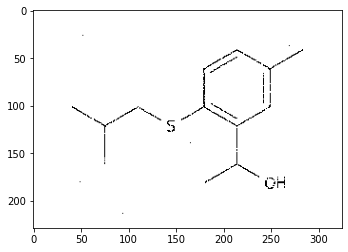

In [6]:
print(df["image_url"].iloc[0])
jpgfile = mpimg.imread(df["image_url"].iloc[0])

plt.imshow(jpgfile, cmap="gray")

In [7]:
x = np.asarray(jpgfile)
x.shape

(229, 325)

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [9]:
class Vocabulary:
    def __init__(self):
        #setting the pre-reserved tokens int to string tokens
        
        #string to int tokens
        #its reverse dict self.itos
        self.stoi={'C': 0,')': 1,'P': 2,'l': 3,'=': 4,'3': 5,'N': 6,'I': 7,'2': 8,'6': 9,'H': 10,'4': 11,'F': 12,'0': 13,'1': 14,'-': 15,'O': 16,'8': 17,
                   ',': 18,'B': 19,'(': 20,'7': 21,'r': 22,'/': 23,'m': 24,'c': 25,'s': 26,'h': 27,'i': 28,'t': 29,'T': 30,'n': 31,'5': 32,'+': 33,'b': 34,'9': 35,
                   'D': 36,'S': 37,'<SOS>': 38,'<EOS>': 39,'<PAD>': 40}
        
        self.itos = {item[1]:item[0] for item in self.stoi.items()}
        
    def __len__(self): return len(self.itos)
    
    @staticmethod
    def tokenize(text):
        return [char for char in text]
    
    def build_vocab(self, sentence_list, freq_threshold):
        frequencies = Counter()
        idx = 4
        
        for sentence in sentence_list:
            for word in self.tokenize(sentence):
                frequencies[word] += 1
                
                #add the word to the vocab if it reaches minum frequecy threshold
                if frequencies[word] == freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1
    
    def numericalize(self,text):
        """ For each word in the text corresponding index token for that word form the vocab built as list """
        tokenized_text = self.tokenize(text)
        return [ self.stoi[token] if token in self.stoi else self.stoi["<UNK>"] for token in tokenized_text ] 

vocab = Vocabulary()
# vocab.build_vocab(df["InChI"].tolist())

In [10]:
transform = Compose([
    #RandomHorizontalFlip(),
    Resize((256,256)),
    #ToTensor(),
    Normalize(mean=[0.5], std=[0.5]),
    ])

In [11]:
class MoleculesDataset(Dataset):
    def __init__(self, data_df, vocab, transform):
        self.df = data_df
        self.transform = transform
        self.vocab = vocab
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        # print(f'Getting item with idx: {idx}')
        row = self.df.iloc[idx]

        pil_img = Image.open(row["image_url"])
        tensor_image = torchvision.transforms.ToTensor()(pil_img)
        
        caption_vec = []
        caption_vec += [self.vocab.stoi["<SOS>"]]
        caption_vec += self.vocab.numericalize(row["InChI"])
        caption_vec += [self.vocab.stoi["<EOS>"]]
        
        return (
            self.transform(tensor_image),
            torch.as_tensor(caption_vec)
        )
    
dataset = MoleculesDataset(df, vocab, transform)

In [12]:
pad_idx = dataset.vocab.stoi["<PAD>"]

class CapsCollate:
    """
    Collate to apply the padding to the captions with dataloader
    """
    def __init__(self,pad_idx,batch_first=False):
        self.pad_idx = pad_idx
        self.batch_first = batch_first
    
    def __call__(self,batch):
        imgs = [item[0].unsqueeze(0) for item in batch]
        imgs = torch.cat(imgs,dim=0)
        
        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first=self.batch_first, padding_value=self.pad_idx)
        return imgs,targets

dataloader = torch.utils.data.DataLoader(
    dataset, 
    batch_size=8, 
    shuffle=True,
    num_workers=0, 
    pin_memory=True,
    collate_fn=CapsCollate(pad_idx=pad_idx,batch_first=True)
)

In [14]:
class EncoderCNN(nn.Module):
    def __init__(self):
        super(EncoderCNN, self).__init__()
        resnet = models.resnet50(pretrained=False)
        resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        for param in resnet.parameters():
            param.requires_grad_(True)
            
        self.resnet = nn.Sequential(*list(resnet.children())[:-2])
        
    def forward(self, images):
        features = self.resnet(images)
        features = features.permute(0, 2, 3, 1)
        features = features.view(features.size(0), -1, features.size(-1))
        # print(features.shape)
        return features

In [15]:
#Bahdanau Attention
class Attention(nn.Module):
    def __init__(self, encoder_dim, decoder_dim, attention_dim):
        super(Attention, self).__init__()
        
        self.attention_dim = attention_dim
        
        self.W = nn.Linear(decoder_dim, attention_dim)
        self.U = nn.Linear(encoder_dim, attention_dim)
        
        self.A = nn.Linear(attention_dim,1)
        
    def forward(self, features, hidden_state):
        u_hs = self.U(features)
        w_ah = self.W(hidden_state)
        
        combined_states = torch.tanh(u_hs + w_ah.unsqueeze(1))
        
        attention_scores = self.A(combined_states)
        attention_scores = attention_scores.squeeze(2)
        
        alpha = F.softmax(attention_scores, dim=1)
        
        attention_weights = features*alpha.unsqueeze(2)
        attention_weights = attention_weights.sum(dim=1)
        
        return alpha, attention_weights

In [16]:
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, vocab_size, attention_dim, encoder_dim, decoder_dim, drop_prob=0.3):
        super().__init__()
        
        self.vocab_size = vocab_size
        self.attention_dim = attention_dim
        self.decoder_dim = decoder_dim
        
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.attention = Attention(encoder_dim, decoder_dim, attention_dim)
        
        self.init_h = nn.Linear(encoder_dim, decoder_dim)
        self.init_c = nn.Linear(encoder_dim, decoder_dim)
        
        self.lstm_cell = nn.LSTMCell(embed_size+encoder_dim, decoder_dim, bias=True)
        self.f_beta = nn.Linear(decoder_dim, encoder_dim)
        
        self.fcn = nn.Linear(decoder_dim, vocab_size)
        self.dropout = nn.Dropout(drop_prob)
        
    def forward(self, features, captions):
        embeds = self.embedding(captions)
        
        #initialize LSTM state
        h, c = self.init_hidden_state(features) #(batch_size, decoder_dim)
        
        #get the seq length to iterate
        seq_length = len(captions[0])-1
        batch_size = captions.size(0)
        num_features = features.size(1)
        
        preds = torch.zeros(batch_size, seq_length, self.vocab_size).to(device)
        alphas = torch.zeros(batch_size, seq_length, num_features).to(device)
        
        for s in range(seq_length):
            alpha, context = self.attention(features, h)
            lstm_input = torch.cat((embeds[:, s], context), dim=1)
            h,c = self.lstm_cell(lstm_input, (h,c))
            
            output = self.fcn(self.dropout(h))
            
            preds[:, s] = output
            alphas[:, s] = alpha
            
        return preds, alphas
    
    def generate_caption(self, features, max_length=120, vocab=None):
        
        batch_size = features.size(0)
        h, c = self.init_hidden_state(features)
        
        alphas=[]
        
        word = torch.tensor(vocab.stoi['<SOS>']).view(1,-1).to(device)
        embeds = self.embedding(word)

        #??
        captions=[]
        
        for i in range(max_length):
            alpha, context = self.attention(features, h)
            
            alphas.append(alpha.cpu().detach().numpy())
            
            lstm_input = torch.cat((embeds[:, 0], context), dim=1)
            h,c = self.lstm_cell(lstm_input, (h,c))
            output = self.fcn(self.dropout(h))
            output = output.view(batch_size,-1)
            
            #select the word
            predicted_word_idx = output.argmax(dim=1)
            
            #save the generated word
            captions.append(predicted_word_idx.item())
            
            if predicted_word_idx.item() == vocab.stoi["<EOS>"]:
                break
            
            #send generated word as the next caption
            embeds = self.embedding(predicted_word_idx.unsqueeze(0))
            
        return [vocab.itos[idx] for idx in captions], alphas
    
    def init_hidden_state(self, encoder_out):
        mean_encoder_out = encoder_out.mean(dim=1)
        h = self.init_h(mean_encoder_out)
        c = self.init_c(mean_encoder_out)
        
        return h,c

In [17]:
class EncoderDecoder(nn.Module):
    def __init__(self, embed_size, vocab_size, attention_dim, encoder_dim, decoder_dim, drop_prob=0.3):
        super().__init__()
        self.encoder = EncoderCNN()
        self.decoder = DecoderRNN(
            embed_size=embed_size,
            vocab_size=vocab_size,
            attention_dim=attention_dim,
            encoder_dim=encoder_dim,
            decoder_dim=decoder_dim
        )
        
    def forward(self, images, captions):
        features = self.encoder(images)
        outputs = self.decoder(features, captions)
        
        return outputs

In [18]:
#Hyperparams
embed_size=200
vocab_size = len(dataset.vocab)
attention_dim=300
encoder_dim=2048
decoder_dim=300

In [19]:
model = EncoderDecoder(
    embed_size=embed_size,
    vocab_size=vocab_size,
    attention_dim=attention_dim,
    encoder_dim=encoder_dim,
    decoder_dim=decoder_dim
).to(device)

loss = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"])
optimizer = optim.Adam(model.parameters(), lr = 3e-4)

In [20]:
#helper function to save the model
def save_model(model,num_epochs):
    model_state = {
        'num_epochs':num_epochs,
        'embed_size':embed_size,
        'vocab_size':len(dataset.vocab),
        'attention_dim':attention_dim,
        'encoder_dim':encoder_dim,
        'decoder_dim':decoder_dim,
        'state_dict':model.state_dict()
    }

    torch.save(model_state,'attention_model_state.pth')

In [21]:
torch.cuda.empty_cache()

  0%|                                                                                                                 | 9/303024 [00:10<80:50:54,  1.04it/s]

Epoch: 1 loss: 2.37205


  0%|                                                                                                                | 10/303024 [00:11<97:17:39,  1.16s/it]

Original caption: <SOS>InChI=1S/C17H24N2O7/c1-10(17(22)26-9-14(20)19(2)3)18-16(21)11-7-12(23-4)15(25-6)13(8-11)24-5/h7-8,10H,9H2,1-6H3,(H,18,21)/t10-/m0/s1<EOS>
Generated caption: II<PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>


  0%|                                                                                                                | 19/303024 [00:19<69:34:20,  1.21it/s]

Epoch: 1 loss: 2.23718


  0%|                                                                                                                | 20/303024 [00:20<83:25:16,  1.01it/s]

Original caption: <SOS>InChI=1S/C25H25NO4S/c1-2-29-25(28)23-21(18-9-4-3-5-10-18)16-31-24(23)26-22(27)15-30-20-13-12-17-8-6-7-11-19(17)14-20/h3-5,9-10,12-14,16H,2,6-8,11,15H2,1H3,(H,26,27)<EOS>
Generated caption: III1111111111-11-11-1-11-1-11-11-11-11-11-11-11-11-11-11-11-11-11-11-11-11-11-11-11-11-11-11-11-11-11-11-11-11-11-11-11-


  0%|                                                                                                                | 29/303024 [00:28<74:52:58,  1.12it/s]

Epoch: 1 loss: 1.74808


  0%|                                                                                                                | 30/303024 [00:30<88:30:29,  1.05s/it]

Original caption: <SOS>InChI=1S/C21H18N2O4/c1-14(24)23-19(11-15-7-3-2-4-8-15)21(26)27-13-20(25)17-12-22-18-10-6-5-9-16(17)18/h2-12,22H,13H2,1H3,(H,23,24)/b19-11+<EOS>
Generated caption: InChI111111111-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1


  0%|                                                                                                                | 39/303024 [00:37<71:09:37,  1.18it/s]

Epoch: 1 loss: 1.82419


  0%|                                                                                                                | 40/303024 [00:39<87:02:00,  1.03s/it]

Original caption: <SOS>InChI=1S/C17H16FN3/c18-16-8-4-7-14(9-16)17(10-19)21-12-15(11-20-21)13-5-2-1-3-6-13/h1-9,11-12,17H,10,19H2<EOS>
Generated caption: InChI1112122212121-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1


  0%|                                                                                                                | 49/303024 [00:46<68:27:22,  1.23it/s]

Epoch: 1 loss: 2.04033


  0%|                                                                                                                | 50/303024 [00:47<80:31:08,  1.05it/s]

Original caption: <SOS>InChI=1S/C18H25BrN2/c19-17-4-2-1-3-16(17)13-20-7-9-21(10-8-20)18-12-14-5-6-15(18)11-14/h1-4,14-15,18H,5-13H2/t14-,15+,18-/m1/s1<EOS>
Generated caption: InChI=1111112121212121-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1


  0%|                                                                                                                | 59/303024 [00:55<70:40:36,  1.19it/s]

Epoch: 1 loss: 1.78049


  0%|                                                                                                                | 60/303024 [00:56<87:00:31,  1.03s/it]

Original caption: <SOS>InChI=1S/C23H26N4O3/c1-29-19-11-10-16(20(15-19)30-2)14-22(28)24-18-8-6-7-17(13-18)23-26-25-21-9-4-3-5-12-27(21)23/h6-8,10-11,13,15H,3-5,9,12,14H2,1-2H3,(H,24,28)<EOS>
Generated caption: InChI=11/11212122121-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1


  0%|                                                                                                                | 69/303024 [01:04<72:49:10,  1.16it/s]

Epoch: 1 loss: 1.59922


  0%|                                                                                                                | 70/303024 [01:06<86:39:27,  1.03s/it]

Original caption: <SOS>InChI=1S/C24H29ClN6O2/c1-26-23(32)17-5-6-20(18(25)13-17)30-10-8-29(9-11-30)15-16-12-19-22(27-14-16)31-7-3-2-4-21(31)24(33)28-19/h5-6,12-14,21H,2-4,7-11,15H2,1H3,(H,26,32)(H,28,33)/t21-/m0/s1<EOS>
Generated caption: InChI=1S/11121212121-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1


  0%|                                                                                                                | 79/303024 [01:14<80:56:55,  1.04it/s]

Epoch: 1 loss: 1.25567


  0%|                                                                                                               | 80/303024 [01:16<105:02:39,  1.25s/it]

Original caption: <SOS>InChI=1S/C21H25ClN2O/c1-3-18(16-9-6-5-7-10-16)21-23-19-15-17(22)11-12-20(19)24(21)13-8-14-25-4-2/h5-7,9-12,15,18H,3-4,8,13-14H2,1-2H3<EOS>
Generated caption: InChI=1S/C11212212212-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-


  0%|                                                                                                                | 89/303024 [01:24<78:46:38,  1.07it/s]

Epoch: 1 loss: 1.59946


  0%|                                                                                                                | 90/303024 [01:26<94:12:27,  1.12s/it]

Original caption: <SOS>InChI=1S/C18H13ClINO4S/c19-13-3-1-2-4-15(13)25-8-7-21-17(23)16(26-18(21)24)10-11-9-12(20)5-6-14(11)22/h1-6,9-10,22H,7-8H2/b16-10-<EOS>
Generated caption: InChI=1S/C1S/11H1222212-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-


  0%|                                                                                                                | 99/303024 [01:33<73:31:50,  1.14it/s]

Epoch: 1 loss: 1.91537


  0%|                                                                                                               | 100/303024 [01:35<86:17:41,  1.03s/it]

Original caption: <SOS>InChI=1S/C22H24N4O2/c1-3-26(4-2)21-15-20(24-22(25-21)16-8-6-5-7-9-16)23-17-10-11-18-19(14-17)28-13-12-27-18/h5-11,14-15H,3-4,12-13H2,1-2H3,(H,23,24,25)<EOS>
Generated caption: InChI=1S/C12H2222222-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1


  0%|                                                                                                               | 109/303024 [01:43<83:04:46,  1.01it/s]

Epoch: 1 loss: 1.40341


  0%|                                                                                                               | 110/303024 [01:45<99:18:43,  1.18s/it]

Original caption: <SOS>InChI=1S/C16H16N2OS/c17-15(20)13-8-4-10-18-16(13)19-14-9-3-6-11-5-1-2-7-12(11)14/h1-2,4-5,7-8,10,14H,3,6,9H2,(H2,17,20)<EOS>
Generated caption: InChI=1S/C11S/C1H212-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1


  0%|                                                                                                               | 119/303024 [01:53<77:04:54,  1.09it/s]

Epoch: 1 loss: 1.37996


  0%|                                                                                                               | 120/303024 [01:54<94:33:23,  1.12s/it]

Original caption: <SOS>InChI=1S/C31H43N5O3/c37-28(35-17-19-36(20-18-35)29(38)31(39)14-15-31)27-33-22-25(23-10-11-26-24(21-23)9-8-16-32-26)30(34-27)12-6-4-2-1-3-5-7-13-30/h8-11,16,21,25,27,33-34,39H,1-7,12-15,17-20,22H2<EOS>
Generated caption: InChI=1S/C12H2222222222-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-


  0%|                                                                                                                                | 0/25 [01:57<?, ?it/s]


RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 4.00 GiB total capacity; 2.70 GiB already allocated; 7.35 MiB free; 2.71 GiB reserved in total by PyTorch)

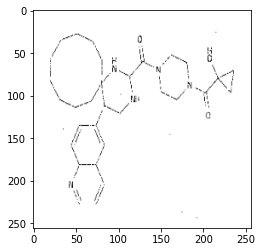

In [22]:
num_epochs=25
print_every=10
iteration = 0
loss_func = nn.CrossEntropyLoss()

for epoch in tqdm(range(1, num_epochs+1)):
    for image, captions in tqdm(dataloader, position=0, leave=True):
        #imageTensor, captions = imageTensor.to(device), captions.to(device)
        image, captions = image.to(device), captions.to(device)

        optimizer.zero_grad()
        
        outputs, attentions = model(image, captions)
        targets = captions[:, 1:]
        
        loss = loss_func(outputs.view(-1, vocab_size), targets.reshape(-1))
        
        loss.backward()
        
        optimizer.step()
        
        if (iteration + 1) % print_every == 0:
            print("Epoch: {} loss: {:.5f}".format(epoch,loss.item()))
            
            model.eval()
            
            with torch.no_grad():
                dataiter = iter(dataloader)
                img, original_captions  = next(dataiter)
                features = model.encoder(img[0:1].to(device))
                caps, alphas = model.decoder.generate_caption(features, vocab=dataset.vocab)
                caption = ''.join(caps)
                 
                original_caption = [vocab.itos[token_id] for token_id in original_captions[0].numpy() if vocab.itos[token_id] != '<PAD>']
                original_caption = ''.join(original_caption)
                print(f'Original caption: {original_caption}')
                print(f'Generated caption: {caption}')
                plt.imshow(img[0].permute(1, 2, 0), cmap='gray')
                
            model.train()
        
        iteration += 1
            
    save_model(model, epoch)